In [1]:
pip install torchtext==0.8.0

In [2]:
import torch
import tqdm
import torch.nn as nn
import numpy as np
import spacy
import torch.optim as optim
import random
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator
from torchtext.data.metrics import bleu_score
import matplotlib.pyplot as plt

In [3]:
torch.cuda.get_device_name()

'Tesla P100-PCIE-16GB'

In [4]:
!python -m spacy download de

✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


In [5]:
spacy_ger = spacy.load("de")
spacy_eng = spacy.load("en")

In [6]:
# def tokenizer(text):
#     return text.split(" ")

In [7]:
def tokenizer_ger(text):
    return [t.text for t in spacy_ger.tokenizer(text)]

def tokenizer_eng(text):
    return [t.text for t in spacy_eng.tokenizer(text)]

In [8]:
german = Field(tokenize=tokenizer_ger, lower=True, init_token="<sos>", eos_token="<eos>")
english = Field(tokenize=tokenizer_eng, lower=True, init_token="<sos>", eos_token="<eos>")

/usr/local/lib/python3.6/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [9]:
train_data, valid_data, test_data = Multi30k.splits(exts=(".de", ".en"), fields=(german, english))

/usr/local/lib/python3.6/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [10]:
len(train_data)

29000

In [11]:
for data in train_data:
    print(vars(data)["src"])
    print(vars(data)["trg"])
    break

['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.']
['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']


In [12]:
german.build_vocab(train_data, max_size=10000, min_freq=2)
english.build_vocab(train_data, max_size=10000, min_freq=2)

In [13]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, p):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.dropout = nn.Dropout(p)

        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, bidirectional=True)
        
        self.fc_hidden = nn.Linear(hidden_size*2, hidden_size)
        self.fc_cell = nn.Linear(hidden_size*2, hidden_size)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        e, (h, c) = self.lstm(x)
        
        h = self.fc_hidden(torch.cat((h[0:1], h[1:2]), dim=2))
        c = self.fc_cell(torch.cat((c[0:1], c[1:2]), dim=2))        

        return e, h, c

In [14]:
class Decoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, ouput_size, p):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.dropout = nn.Dropout(p)

        self.energy = nn.Linear(hidden_size*3, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=0)
        
        self.lstm = nn.LSTM(embedding_size + hidden_size*2, hidden_size, num_layers, dropout=p)
        self.fc = nn.Linear(hidden_size, output_size)

        
    def forward(self, x, e, h, c):
        x = x.unsqueeze(0)
        x = self.embedding(x)
        x = self.dropout(x)

        seq_len = e.shape[0]
        h_ = h.repeat(seq_len, 1, 1)

        energy = self.energy(torch.cat((h_, e), dim=2))
        energy = self.relu(energy)
        attention = self.softmax(energy)

        context_vector = torch.einsum("snk,snl->knl", attention, e)
        x = torch.cat((context_vector, x), dim=2)

        x, (h, c) = self.lstm(x, (h, c))
        x = self.fc(x)
        x = x.squeeze(0)
        return x, h, c

In [15]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder_net, decoder_net):
        super().__init__()
        self.encoder = encoder_net
        self.decoder = decoder_net

    def forward(self, X, y, teacher_force_ratio=0.5):
        batch_size = X.shape[1]
        y_len = y.shape[0]
        y_vocab_size = len(english.vocab)
        
        output = torch.zeros(y_len, batch_size, y_vocab_size).to(device)

        e, h, c = self.encoder(X)
        x = y[0]

        for i in range(1, y_len):
            x, h, c = self.decoder(x, e, h, c)
            output[i] = x
            pred = x.argmax(1)
            if random.random() > teacher_force_ratio:
                x = y[i]
            else:
                x = pred
        
        return output

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 16
lr = 1e-3
batch_size = 64
encoder_input_size = len(german.vocab)
decoder_input_size = len(english.vocab)
output_size = len(english.vocab)
encoder_embedding_size = 300
decoder_embedding_size = 300
hidden_size = 1024
num_layers = 1
p = 0

In [17]:
device

device(type='cuda')

In [18]:
train_batches, valid_batches, test_batches = BucketIterator.splits((train_data, valid_data, test_data), batch_size=batch_size,
                                                                 sort_within_batch=True, sort_key=lambda x: len(x.src),
                                                                 device=device)

/usr/local/lib/python3.6/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [19]:
for batch in train_batches:
    ger = batch.src
    eng = batch.trg
    print(eng.shape, ger.shape)
    break

/usr/local/lib/python3.6/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


torch.Size([19, 64]) torch.Size([13, 64])


In [20]:
encoder_net = Encoder(encoder_input_size, encoder_embedding_size, hidden_size, num_layers, p).to(device)
decoder_net = Decoder(decoder_input_size, decoder_embedding_size, hidden_size, num_layers, output_size, p).to(device)
net = Seq2Seq(encoder_net, decoder_net).to(device)

In [21]:
net

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7855, 300)
    (dropout): Dropout(p=0, inplace=False)
    (lstm): LSTM(300, 1024, bidirectional=True)
    (fc_hidden): Linear(in_features=2048, out_features=1024, bias=True)
    (fc_cell): Linear(in_features=2048, out_features=1024, bias=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(5893, 300)
    (dropout): Dropout(p=0, inplace=False)
    (energy): Linear(in_features=3072, out_features=1, bias=True)
    (relu): ReLU()
    (softmax): Softmax(dim=0)
    (lstm): LSTM(2348, 1024)
    (fc): Linear(in_features=1024, out_features=5893, bias=True)
  )
)

In [22]:
opt = optim.Adam(net.parameters(), lr)
pad_idx = english.vocab.stoi["<pad>"]
loss_fn = nn.CrossEntropyLoss(ignore_index=pad_idx)

In [23]:
len(train_batches)

454

In [24]:
def translate(net, sentence, german, english, device, max_len=50):
    if type(sentence) == str:
        tokens = [t.text.lower() for t in spacy_ger(sentence)]
    else:
        tokens = [t.lower() for t in sentence]

    tokens.insert(0, "<sos>")
    tokens.append("<eos>")

    text2idx = []
    for t in tokens:
        text2idx.append(german.vocab.stoi[t])
    
    text_tensor = torch.LongTensor(text2idx)
    text_tensor = text_tensor.unsqueeze(1).to(device)
    with torch.no_grad():
        e, h, c = net.encoder(text_tensor)
    
    output = [english.vocab.stoi["<sos>"]]
    for _ in range(max_len):
        prev_word = torch.LongTensor([output[-1]]).to(device)
        with torch.no_grad():
            p, h, c = net.decoder(prev_word, e, h, c)
            pred = p.argmax(1).item()

        output.append(pred)
        if pred == english.vocab.stoi["<eos>"]:
            break

    output_text = [english.vocab.itos[idx] for idx in output]

    return output_text[1:]

In [25]:
def bleu(data, net, german, english, device):
    targets = []
    outputs = []

    for d in data:
        src = vars(d)["src"]
        trg = vars(d)["trg"]

        prediction = translate(net, src, german, english, device)
        prediction = prediction[:-1]  

        targets.append([trg])
        outputs.append(prediction)
       
    return bleu_score(outputs, targets)

In [26]:
def save_checkpoint(net, opt, losses, filename):
    check_point = {"net_dict": net.state_dict(), "opt_dict": opt.state_dict(), "losses": losses}
    torch.save(check_point, filename)
    print("Checkpoint Saved!")

def load_checkpoint(net, opt, filename):
    check_point = torch.load(filename)
    net.load_state_dict(check_point["net_dict"])
    opt.load_state_dict(check_point["opt_dict"])
    losses = check_point["losses"]
    print("Checkpoint Loaded!")

In [27]:
t = [[['that', 'is', 'a', 'plane', 'and', 'not', 'a', 'bird']]]
o = [['that', 'is', 'a', 'plane', 'and', 'not', 'a', 'dog']]
bleu_score(o, t)

0.8408964276313782

In [28]:
text = "ein boot mit mehreren männern darauf wird von einem großen pferdegespann ans ufer gezogen"
english_translation = "a boat with several men on it is being pulled ashore by a large team of horses"

In [29]:
losses = []

In [30]:
for epoch in range(epochs):
    batch_losses = []
    for batch in tqdm.tqdm(train_batches, total=len(train_batches)):
        X = batch.src.to(device)
        y = batch.trg.to(device)

        output = net(X, y)
        output = output[1:].reshape(-1, output.shape[2])
        y = y[1:].reshape(-1)
        
        opt.zero_grad()
        loss = loss_fn(output, y)
        loss.backward()
        batch_losses.append(loss.item())
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1)
        opt.step()
    
    losses.append(np.round(sum(batch_losses)/len(batch_losses), 5))
    print(f" Epoch: {epoch} | Loss: {losses[epoch]:4f}")

    pred_list = translate(net, text, german, english, device, max_len=50)
    pred_text = ""
    for word in pred_list:
        pred_text += word + " "

    print(pred_text)
    print("")

    if epoch % 5 == 0:
        save_checkpoint(net, opt, losses, f"checkpoint-{epoch}.pth.tar")
        print("")

  0%|          | 0/454 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
100%|██████████| 454/454 [00:47<00:00,  9.55it/s]


 Epoch: 0 | Loss: 4.089630
a man with a <unk> <unk> a a a a large of a . <eos> 



  0%|          | 1/454 [00:00<01:12,  6.25it/s]

Checkpoint Saved!



  0%|          | 1/454 [00:00<01:05,  6.90it/s]

 Epoch: 1 | Loss: 3.044260
a man with a is surrounded by a large of a large . . <eos> 



  0%|          | 1/454 [00:00<00:56,  7.99it/s]

 Epoch: 2 | Loss: 2.525670
a fisherman with a couple is being pulled by a large by a large . . <eos> 



  0%|          | 1/454 [00:00<01:10,  6.43it/s]

 Epoch: 3 | Loss: 2.103670
a boat with several men are pulled by a large of of . <eos> 



  0%|          | 1/454 [00:00<01:02,  7.19it/s]

 Epoch: 4 | Loss: 1.738620
a boat with several and fish by large by large by large cable . <eos> 



100%|██████████| 454/454 [00:47<00:00,  9.53it/s]


 Epoch: 5 | Loss: 1.388960
a boat with several men are pulled by a basket of a large basket . <eos> 



  0%|          | 1/454 [00:00<01:20,  5.60it/s]

Checkpoint Saved!



  0%|          | 1/454 [00:00<01:02,  7.29it/s]

 Epoch: 6 | Loss: 1.078020
a boat with several men being pulled by a by a by a large horses . <eos> 



  0%|          | 1/454 [00:00<01:05,  6.94it/s]

 Epoch: 7 | Loss: 0.828330
a boat carrying several men is <unk> by a large cable of of dogs on the shore . <eos> 



  0%|          | 1/454 [00:00<01:06,  6.85it/s]

 Epoch: 8 | Loss: 0.612470
a boat carrying several men is pulled from the sides of a large number 4 . <eos> 



  0%|          | 1/454 [00:00<01:04,  7.02it/s]

 Epoch: 9 | Loss: 0.460430
a boat carrying several men is pulled by horses and by horses to horses . <eos> 



100%|██████████| 454/454 [00:47<00:00,  9.55it/s]


 Epoch: 10 | Loss: 0.342550
a boat carrying several men is pulled to shore by a by several of horses by to shore . <eos> 



  0%|          | 1/454 [00:00<01:13,  6.12it/s]

Checkpoint Saved!



  0%|          | 1/454 [00:00<01:06,  6.78it/s]

 Epoch: 11 | Loss: 0.253110
a boat carrying several men is pulled to shore by a large team of horses . <eos> 



  0%|          | 1/454 [00:00<01:03,  7.10it/s]

 Epoch: 12 | Loss: 0.199250
a boat carrying several men is pulled to shore by a large team of horses . <eos> 



  0%|          | 1/454 [00:00<01:07,  6.75it/s]

 Epoch: 13 | Loss: 0.167510
a boat carrying several men is pulled by shore by a large team of horses . <eos> 



  0%|          | 1/454 [00:00<01:05,  6.96it/s]

 Epoch: 14 | Loss: 0.158010
a boat carrying several men is pulled to shore by a large team of horses . <eos> 



100%|██████████| 454/454 [00:47<00:00,  9.59it/s]


 Epoch: 15 | Loss: 0.153680
a boat carrying several men is pulled to shore by a large team of horses . <eos> 

Checkpoint Saved!



Text(0, 0.5, 'loss')

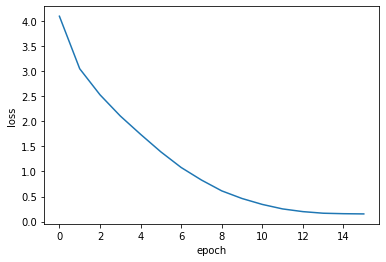

In [31]:
plt.plot(losses)
plt.xlabel("epoch")
plt.ylabel("loss")

In [32]:
len(test_data)

1000

In [35]:
score = bleu(test_data, net, german, english, device) * 100
print(f"Bleu Score: {score}")

Bleu Score: 26.3038520180978


In [36]:
# bleu score interpretation:
# 0 - 19: bad translations
# 20 - 29: understandable translations
# 30 - 39: good translations
# 40 - 49: High quality translations
# 50 - 60: Very high quality, adequate, and fluent translations
# > 60: Quality often better than human

In [41]:
text1 = "Ein Mann geht die Straße entlang, während er eine Tasse in der Hand hält"
og_translation1 = "a man is walking down the street while holding a cup"

In [42]:
pred_list = translate(net, text1, german, english, device)
pred_text = ""
for word in pred_list:
    pred_text += word + " "

print(pred_text)
print("")

a man walking down the street holding a cup of food . <eos> 



In [47]:
text2 = "Dieser Affe klettert auf einen Baum"
og_translation2 = "that monkey is climbing a tree"

In [48]:
pred_list = translate(net, text2, german, english, device)
pred_text = ""
for word in pred_list:
    pred_text += word + " "

print(pred_text)
print("")

this is climbing climbing a tree . <eos> 



In [53]:
text3 = "Dieser Mann rennt zu langsam, um den Bus zu erreichen"
og_translation3 = "that man is running too slow to catch the bus"

In [54]:
pred_list = translate(net, text3, german, english, device)
pred_text = ""
for word in pred_list:
    pred_text += word + " "

print(pred_text)
print("")

this man is running to run to go down the bus . <eos> 

